In [1]:
import numpy as np
from scipy import optimize, linalg
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
np.random.seed(16082011)

 - http://www.users.on.net/~zygmunt.szpak/ellipsefitting.html
 - https://www.researchgate.net/publication/3659879_Direct_Least-squares_fitting_of_ellipses/link/00463531e42a2a932f000000/download
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
 - https://en.wikipedia.org/wiki/Rayleigh_quotient
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint

In [4]:
def scale(a=2, b=1):
    return np.array([[a, 0], [0, b]])

In [5]:
def rotation(alpha=np.pi/4):
    return np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha),  np.cos(alpha)]
    ])

In [6]:
def circle(phi, rho=1):
    return rho*np.array([np.cos(phi), np.sin(phi)])

In [7]:
def ellipse(phi, rho, alpha, S, Xc):
    C = circle(phi, rho=rho)
    R = rotation(alpha)
    S = scale(*S)
    Xc = np.array(Xc)
    return np.dot(R, np.dot(S, C)).T + Xc

In [8]:
def phi(A, B, C):
    if np.isclose(B, 0):
        return 1
    else:
        return np.arctan((C-A-np.sqrt((A-C)**2+B**2))/B)

$$\begin{align}
  a, b    &= \frac{-\sqrt{2 \Big(A E^2 + C D^2 - B D E + (B^2 - 4 A C) F\Big)\left((A + C) \pm \sqrt{(A - C)^2 + B^2}\right)}}{B^2 - 4 A C} \\
  x_\circ  &= \frac{2CD - BE}{B^2 - 4AC} \\[3pt]
  y_\circ  &= \frac{2AE - BD}{B^2 - 4AC} \\[3pt]
    \Theta &= \begin{cases}
                \arctan\left(\frac{1}{B}\left(C - A - \sqrt{(A - C)^2 + B^2}\right)\right)
                         & \text{for } B \ne 0 \\
                       0 & \text{for } B = 0,\ A < C \\
                90^\circ & \text{for } B = 0,\ A > C \\
              \end{cases}
\end{align}$$

In [9]:
def params(A, B, C, D, E, F):
    return [
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)+np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)-np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        (2*C*D-B*E)/(B**2-4*A*C),
        (2*A*E-B*D)/(B**2-4*A*C),
        phi(A, B, C)
    ]

In [10]:
def objective(x, A, B, C, D, E):
    return A*x[:,0]**2 + B*x[:,0]*x[:,1] + C*x[:,1]**2 + D*x[:,0] + E*x[:,1]

In [11]:
def u(x):
    return np.array([x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2, x[:,0], x[:,1], np.ones_like(x[:,0])])

In [12]:
def obj(theta, C):
    theta = np.array(theta).T
    return np.dot(np.dot(theta.T, C), theta)

In [13]:
def constraint(x):
    return x[1]**2 - 4*x[0]*x[1]

In [14]:
F = np.zeros((6, 6))
F[0,2] = 2
F[2,0] = 2
F[1,1] = -1

```matlab
function a = direct_ellipse_fit(data)
    x = data(1,:)';
    y = data(2,:)';
    
    D1 = [x .^ 2, x .* y, y .^ 2]; % quadratic part of the design matrix
    D2 = [x, y, ones(size(x))];    % linear part of the design matrix
    S1 = D1' * D1;                 % quadratic part of the scatter matrix
    S2 = D1' * D2;                 % combined part of the scatter matrix
    S3 = D2' * D2;                 % linear part of the scatter matrix
    T = - inv(S3) * S2';           % for getting a2 from a1
    M = S1 + S2 * T;               % reduce scatter matrix
    M = [M(3, :) ./2; - M(2, :); M(1, :) ./2]; % premultiply by inv(C1)
    [evec, evalue] = eig(M);       % solve eigensystem
    cond = 4 * evec(1, :) .* evec(3, :) - evec(2, :) .^ 2; % evaluate a'Ca
    al = evec(:, find(cond > 0));  % eigenvector for min. pos. eigenvalue
    a = [al; T * al];              % ellipse coefficients
    a = a/norm(a);
end
```

In [64]:
def DIF(X):
    x = X[:,0]
    y = X[:,1]
    D1 = np.array([x**2, x*y, y**2]).T
    D2 = np.array([x, y, np.ones_like(x)]).T
    S1 = np.dot(D1.T, D1)
    S2 = np.dot(D1.T, D2)
    S3 = np.dot(D2.T, D2)
    T = np.linalg.inv(S3)*S2.T
    M = S1 + np.dot(S2, T)
    M = np.array([M[2,:]/2, -M[1,:], M[0,:]/2]).T
    l, v = np.linalg.eig(M)
    cond = 4*v[:,2]*v[:,0] - v[:,1]**2
    cidx = np.where(cond>0)
    al = v[:, cidx[0]]
    print(np.where(cond>0))
    a = np.array(al.reshape(-1).tolist() + np.dot(T, al).reshape(-1).tolist())
    #a = a/np.linalg.norm(a)
    return a

In [65]:
t1 = np.linspace(np.pi/2, 4/2*np.pi+0.25, 200)
t1 = np.linspace(np.pi/2, 4/2*np.pi+0.25, 200)
t2 = np.linspace(np.pi/2+0.25, 3/2*np.pi+0.25, 200)
t3 = np.linspace(0, np.pi, 200)
t4 = np.linspace(np.pi/2+0.25, 3/2*np.pi-0.25, 200)
t5 = np.linspace(0, 2*np.pi, 200)

In [66]:
t0 = np.linspace(0, 2*np.pi, 200)
e = np.random.randn(t0.size)*1e-1

In [67]:
alpha = np.pi/4
S = [5, 3]
Xc = [2, 1]

In [68]:
X0 = ellipse(phi=t0, rho=1, alpha=alpha, S=S, Xc=Xc)

(array([1], dtype=int64),)
[ 4.10382256e-01 -2.04168203e-01 -8.88764169e-01  1.23273796e+03
  2.53639156e+03 -3.74508997e+03]
(array([1], dtype=int64),)
[ 3.46863695e-01 -1.55940916e-01 -9.24861075e-01  5.11156272e+02
  3.11654763e+03 -3.60261380e+03]
(array([2], dtype=int64),)
[ 3.25439191e-01  5.17544092e-01  7.91351658e-01  5.39940580e+01
 -2.53222402e+03  2.46283008e+03]
(array([2], dtype=int64),)
[ 2.17204069e-01  4.48301845e-01  8.67091603e-01  2.88570837e+02
 -2.50407555e+03  2.19830413e+03]
(array([2], dtype=int64),)
[ 1.13265955e-01  3.49312159e-01  9.30135387e-01  3.26328668e+02
 -2.09711239e+03  1.75384497e+03]
(array([2], dtype=int64),)
[ 3.35783978e-01  5.46615829e-01  7.67111631e-01  1.08117821e+02
 -1.68992768e+03  1.56915906e+03]
(array([2], dtype=int64),)
[ 2.17749527e-01  4.82919387e-01  8.48159188e-01  2.91041064e+02
 -1.73318363e+03  1.42793821e+03]
(array([2], dtype=int64),)
[ 9.87959039e-02  3.88995132e-01  9.15926939e-01  3.49477726e+02
 -1.52967799e+03  1.166713

TypeError: params() takes 6 positional arguments but 12 were given

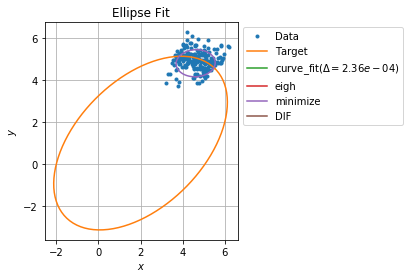

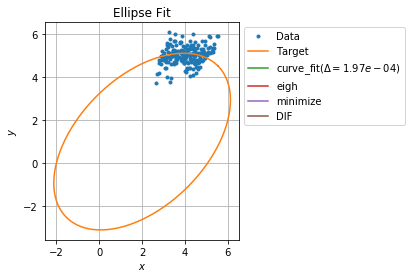

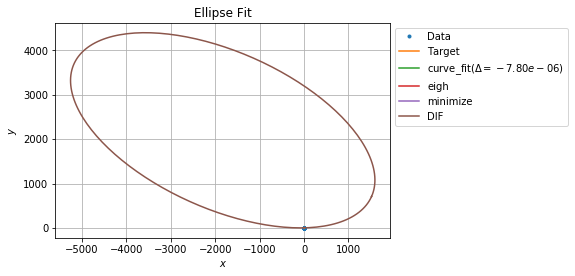

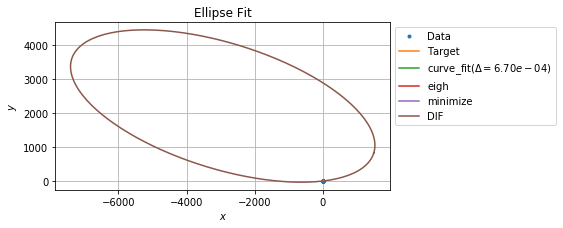

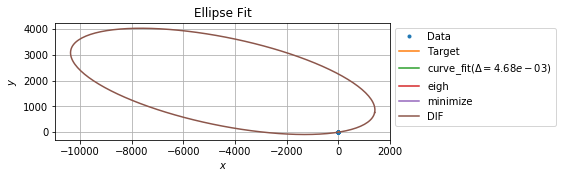

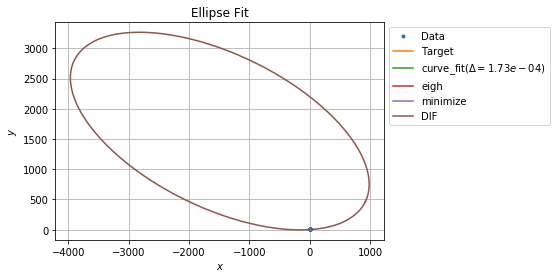

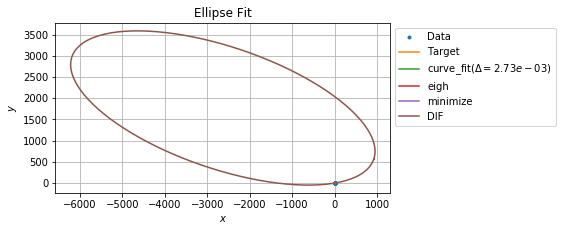

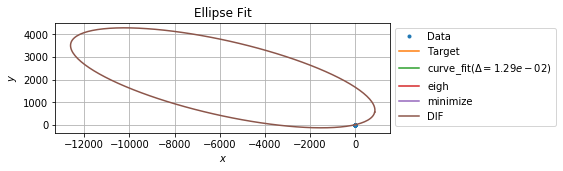

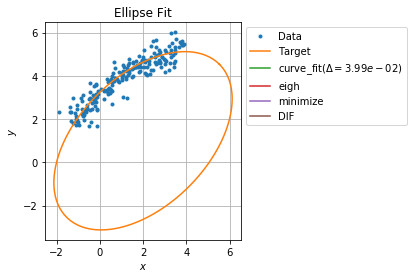

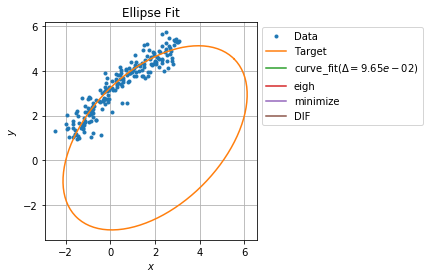

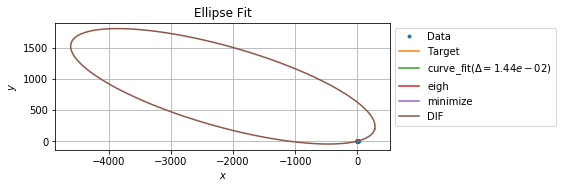

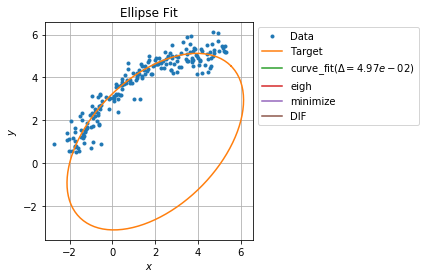

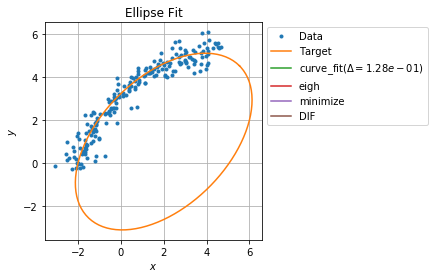

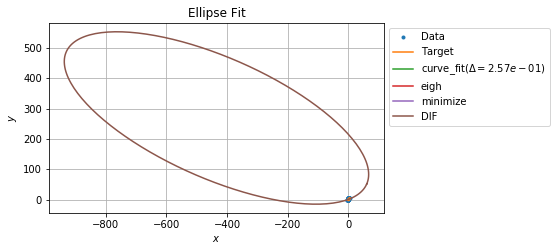

In [69]:
for r in np.linspace(0.1, 1.0, 9):
    for p in np.linspace(0, np.pi/4, 5):
        t = np.linspace(p, 2*r*np.pi+p, 200)
        # Generate Ellipse Data:
        X = ellipse(phi=t, rho=1+e, alpha=alpha, S=S, Xc=Xc)
        # Dummy fit:
        optsol1, optcov1 = optimize.curve_fit(objective, X, np.ones_like(X[:,0]))
        d1 = constraint(optsol1)
        r1 = np.array(params(*(list(optsol1)+[-1])))
        Xhat1 = ellipse(phi=t0, rho=1, alpha=r1[4], S=r1[:2], Xc=r1[2:4])
        # Rayleight:
        Xb = u(X).T
        M = np.dot(Xb.T, Xb)
        l, U = linalg.eigh(F, M)
        r2 = np.array(params(*U[:,0]))
        Xhat2 = ellipse(phi=t0, rho=1, alpha=r2[4], S=r2[:2], Xc=r2[2:4])
        # Constraints:
        nlc = optimize.NonlinearConstraint(constraint, 0, np.inf)
        optsol3 = optimize.minimize(obj, np.ones(6), args=(M,), constraints=nlc, tol=1e-13)
        r3 = params(*optsol3.x)
        Xhat3 = ellipse(phi=t0, rho=1, alpha=r3[4], S=r3[:2], Xc=r3[2:4])
        # DIF:
        optsol4 = DIF(X)
        print(optsol4)
        r4 = params(*optsol4)
        Xhat4 = ellipse(phi=t0, rho=1, alpha=r4[4], S=r4[:2], Xc=r4[2:4])
        # Plot
        fig, axe = plt.subplots()
        axe.plot(X[:,0], X[:,1], '.', label='Data')
        axe.plot(X0[:,0], X0[:,1], label='Target')
        axe.plot(Xhat1[:,0], Xhat1[:,1], label='curve_fit($\Delta=%.2e$)' % d1)
        axe.plot(Xhat2[:,0], Xhat2[:,1], label='eigh')
        axe.plot(Xhat3[:,0], Xhat3[:,1], label='minimize')
        axe.plot(Xhat4[:,0], Xhat4[:,1], label='DIF')
        axe.set_title('Ellipse Fit')
        axe.set_xlabel('$x$')
        axe.set_ylabel('$y$')
        axe.set_aspect('equal', adjustable='box')
        axe.legend(bbox_to_anchor=(1,1))
        axe.grid()

In [ ]:
DIF(X)

In [ ]:
params(*_[-1])